In [1]:

print("Let it begin boys")
!pip install -q --upgrade pip
!pip install -q torch torchvision torchaudio
!pip install -q diffusers transformers accelerate
!pip install -q peft bitsandbytes datasets safetensors

print("\n" + "="*80)
print("Verification")
print("="*80)

import torch
import diffusers
import transformers
import bitsandbytes

print(f"✓ PyTorch: {torch.__version__}")
print(f"✓ Diffusers: {diffusers.__version__}")
print(f"✓ Transformers: {transformers.__version__}")
print(f"✓ CUDA: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

print("LFG!")

Let it begin boys

Verification
✓ PyTorch: 2.8.0+cu126
✓ Diffusers: 0.35.2
✓ Transformers: 4.57.1
✓ CUDA: True
✓ GPU: Tesla T4
LFG!


In [2]:

# google colab use
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install peft==0.5.0


In [4]:
print("importing stuff")
import os, gc, json, time, math
from pathlib import Path
from dataclasses import dataclass, asdict
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
import torchvision.transforms as T

importing stuff


In [5]:
# Dataset tool
from datasets import load_dataset
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

In [6]:
#Print the version info and all
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

Torch: 2.8.0+cu126 | CUDA available: True
Device: Tesla T4


In [7]:
# Hugging Face & PEFT
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    DDPMScheduler,
    StableDiffusionXLPipeline
)
from transformers import CLIPTokenizer, CLIPTextModel, CLIPTextModelWithProjection

In [8]:
# 1. Define the path on your Drive
drive_model_path = "/content/drive/MyDrive/sdxl-base-1.0"
os.makedirs(drive_model_path, exist_ok=True)
print(f" Downloading and saving base model to: {drive_model_path}")
#define model id
model_id = "stabilityai/stable-diffusion-xl-base-1.0"

In [9]:
print("Saving Tokenizers...")
CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer").save_pretrained(f"{drive_model_path}/tokenizer")
CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer_2").save_pretrained(f"{drive_model_path}/tokenizer_2")





print("Saving Scheduler...")
DDPMScheduler.from_pretrained(model_id, subfolder="scheduler").save_pretrained(f"{drive_model_path}/scheduler")


Saving Tokenizers...


tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

Saving Scheduler...


scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

In [10]:
print("Saving Text Encoders...")
CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", torch_dtype=torch.float16).save_pretrained(f"{drive_model_path}/text_encoder")
CLIPTextModelWithProjection.from_pretrained(model_id, subfolder="text_encoder_2", torch_dtype=torch.float16).save_pretrained(f"{drive_model_path}/text_encoder_2")

`torch_dtype` is deprecated! Use `dtype` instead!


Saving Text Encoders...


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

In [11]:
print("Saving VAE...")
AutoencoderKL.from_pretrained(model_id, subfolder="vae", torch_dtype=torch.float32).save_pretrained(f"{drive_model_path}/vae")

Saving VAE...


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [12]:
print("Saving UNet")
UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", torch_dtype=torch.float16).save_pretrained(f"{drive_model_path}/unet")

Saving UNet


config.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

In [44]:
#training configurations
@dataclass
class TraininigConfiguration:
  modelId: str = "/content/drive/MyDrive/sdxl-base-1.0"
  datasetId: str = "lambdalabs/naruto-blip-captions"
  #establish the output directories where we will have output, logs and checkpoints
  outputDir: str = "/content/drive/MyDrive/Naruto_FineTune/output"
  logsDir: str = "/content/drive/MyDrive/Naruto_FineTune/logs"
  checkpointsDir: str = "/content/drive/MyDrive/Naruto_FineTune/checkpoints"
  #Training Hyperparamters
  resolution: int = 512
  train_batch_size: int = 1 #in docs
  gradient_accumulation_steps: int = 4
  num_train_epochs: int = 3
  learning_rate: float = 1e-4
  learning_rate_warmup_steps: int = 10
  learning_rate_scheduler_type: str = "cosine"


  # Optimizations
  mixed_precision: str = "fp16"
  grad_checkpointing : bool = True
  use_8bit_adam: bool = True
  max_grad_norm: float = 1.0

  #For a quick dry run let us set some dataset limits that will be used later
  max_train_samples: int = 150
  seed: int = 42

  #checkpoints
  save_every_step = 250

  #peft;
  # PEFT (LoRA/DoRA)
  lora_rank: int = 16
  lora_alpha: int = 32
  lora_dropout: float = 0.1
  lora_target_modules: tuple = ("to_q","to_k","to_v","to_out.0")

  #debug
  debug: bool = True
  dry_run_steps: int = 15
  mini_dataset_mode: bool = False #do set to false when you have to for the entire dataset for the final fine tuning

config = TraininigConfiguration()

In [9]:
# Dataset and dataloader prep
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode

In [10]:
ds = load_dataset(config.datasetId, split = "train")
if config.mini_dataset_mode:
    print(f"Training using the mini dataset as the mini dataset mode is set to true in the config and we weiil use the first {config.max_train_samples} samples out of {len(ds)}")
    ds = ds.select(range(config.max_train_samples))


README.md: 0.00B [00:00, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

data/train-00000-of-00002-12944970063701(…):   0%|          | 0.00/344M [00:00<?, ?B/s]

data/train-00001-of-00002-cefa2f480689f1(…):   0%|          | 0.00/357M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [11]:
if config.max_train_samples is not None:
    raw_ds = ds.select(range(min(config.max_train_samples, len(ds))))
print(f"Dataset size: {len(ds)}")


Dataset size: 1221


In [12]:
example_of_dataset = ds[0]
print('it looks something like this', example_of_dataset)

it looks something like this {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1080x1080 at 0x7BC53281F0B0>, 'text': 'a man with dark hair and brown eyes'}


In [13]:
print('it looks something like this', example_of_dataset.keys())

it looks something like this dict_keys(['image', 'text'])


In [14]:
print('it looks something like this', example_of_dataset.get('text'))

it looks something like this a man with dark hair and brown eyes


In [15]:
#Tokenizers
tokenizer_one = CLIPTokenizer.from_pretrained(config.modelId, subfolder="tokenizer")
tokenizer_two = CLIPTokenizer.from_pretrained(config.modelId, subfolder="tokenizer_2")
print("Tokenizers loaded.")

Tokenizers loaded.


In [16]:
#Dataset class
class DatasetOfNaruto(Dataset):
  def __init__(self,hf_dataset,tokenizer_one,tokenizer_two, resolution=512):
    self.ds = hf_dataset
    self.tokenizer_1 = tokenizer_one
    self.tokenizer_2 = tokenizer_two
    self.resolution= resolution
    self.transform = T.Compose([
      T.Resize((resolution, resolution), interpolation=InterpolationMode.BILINEAR),
      T.CenterCrop((resolution, resolution)),
      T.RandomHorizontalFlip(p=0.5),
      T.ToTensor(),
      T.Normalize([0.5]*3, [0.5]*3)
    ])

  def __len__(self):
    return len(self.ds)

  def tokenizer_captions(self,text):
    tok_caption_1 = self.tokenizer_1(text, padding="max_length", truncation=True, max_length=self.tokenizer_1.model_max_length, return_tensors="pt")
    tok_caption_2 = self.tokenizer_2(text, padding="max_length", truncation=True, max_length=self.tokenizer_2.model_max_length, return_tensors="pt")
    return tok_caption_1.input_ids.squeeze(0), tok_caption_2.input_ids.squeeze(0)

  def __getitem__(self,idx):
    item = self.ds[idx]
    img = item["image"]
    pixel_values = self.transform(img)
    caption = item.get("text") or item.get("caption") or item.get("title") or ""
    ids1, ids2 = self.tokenizer_captions(caption)
    return {"pixel_values": pixel_values, "input_ids_one": ids1, "input_ids_two": ids2, "caption": caption}


In [17]:
#dataset and dataloader
train_ds = DatasetOfNaruto(ds, tokenizer_one, tokenizer_two, resolution=config.resolution)
train_loader = DataLoader(train_ds, batch_size=config.train_batch_size, shuffle = True, num_workers = 2, pin_memory=True)


In [18]:
print("Dataloader ready. Number of batches per epoch:", len(train_loader))

Dataloader ready. Number of batches per epoch: 1221


In [19]:
batch = next(iter(train_loader))
print("Batch keys:", batch.keys())
print("Pixel values shape:", batch["pixel_values"].shape)
print("Caption (first):", batch["caption"][0])

Batch keys: dict_keys(['pixel_values', 'input_ids_one', 'input_ids_two', 'caption'])
Pixel values shape: torch.Size([1, 3, 512, 512])
Caption (first): a man in a white shirt and vest


In [20]:
#Load the models
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from transformers import CLIPTextModel, CLIPTextModelWithProjection

In [21]:
#load the text encoders
text_encoder_1 = CLIPTextModel.from_pretrained(config.modelId, subfolder="text_encoder", torch_dtype = torch.float16, device_map="cpu")
text_encoder_2 = CLIPTextModel.from_pretrained(config.modelId, subfolder="text_encoder_2", torch_dtype = torch.float16, device_map="cpu")


`torch_dtype` is deprecated! Use `dtype` instead!


In [22]:
acc = Accelerator(
    gradient_accumulation_steps = config.gradient_accumulation_steps,
    mixed_precision=config.mixed_precision,
)

In [23]:
vae = AutoencoderKL.from_pretrained(
    config.modelId,
    subfolder="vae",
    torch_dtype=torch.float32,   # MUST be float32
)
vae.requires_grad_(False)
vae.to(acc.device) #to be noted that this VAE is the worst piece of thing ever - needs to be trained on the gpu but make sure that the dtype is float32 and not 16 -> this will cause mismatch error in data types if you do this -> personal notes

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [24]:
#load the unet
unet = UNet2DConditionModel.from_pretrained(config.modelId, subfolder="unet", torch_dtype=torch.float16, device_map="cpu")


In [25]:
#noise scheduler
noise_scheduler = DDPMScheduler.from_pretrained(config.modelId, subfolder="scheduler")

In [26]:
#now we will freeze te1, te1 and vae
for p in text_encoder_1.parameters():
  p.requires_grad=False
for p in text_encoder_2.parameters():
  p.requires_grad=False

for p in vae.parameters():
  p.requires_grad=False



In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [28]:
def cuda_mem_report(prefix=""):
    torch.cuda.empty_cache()
    gc.collect()
    if torch.cuda.is_available():
        print(f"{prefix} Allocated: {torch.cuda.memory_allocated() / 1e9:.3f} GB | Reserved: {torch.cuda.memory_reserved() / 1e9:.3f} GB")
    else:
        print(f"{prefix} No CUDA available")

cuda_mem_report("After imports:")

After imports: Allocated: 0.336 GB | Reserved: 0.373 GB


In [29]:
try:
    print("Moving Unet to GPU")
    unet.to(device=device)
    cuda_mem_report("After moving UNet:")
except RuntimeError as e:
    print("Well damn, out of memory error!!!!!!!!!!", e)
    unet.to(device="cpu")

Moving Unet to GPU
After moving UNet: Allocated: 5.578 GB | Reserved: 5.761 GB


In [30]:
if config.grad_checkpointing:
    try:
        unet.enable_gradient_checkpointing()
        print("Gradient Checpointting is enabled on the UNet - Nice!")
    except Exception as e:
        print("Not enabled!!!!!!:", e)

Gradient Checpointting is enabled on the UNet - Nice!


In [31]:
trainable_parameters = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print(f"Total trainable parameters are :", trainable_parameters)

Total trainable parameters are : 2567463684


In [32]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

In [33]:
# Apply PEFT techniques to the model - https://huggingface.co/docs/peft/en/package_reference/lora
print("LORAAAAAAAAA")
#Build LoraConfig
lora_config=LoraConfig(
    r=config.lora_rank,
    lora_alpha= config.lora_alpha,
    target_modules = list(config.lora_target_modules),
    lora_dropout = config.lora_dropout,
    bias="none",
)

LORAAAAAAAAA


In [34]:
unet = get_peft_model(unet, lora_config)

In [35]:
trainable_after = sum(p.numel() for p in unet.parameters() if p.requires_grad)
total_after = sum(p.numel() for p in unet.parameters())
print(f"UNet trainable params after PEFT: {trainable_after:,} / {total_after:,} ({100*trainable_after/total_after:.4f}%)")


UNet trainable params after PEFT: 23,224,320 / 2,590,688,004 (0.8965%)


In [36]:
#oprtimizer and scheduler
from transformers import get_scheduler

In [37]:
device = acc.device
print("Accelerator device:", device)

Accelerator device: cuda


In [38]:
import bitsandbytes as bnb

In [39]:
if config.use_8bit_adam:
  import bitsandbytes as bnb
  optm = bnb.optim.AdamW8bit(unet.parameters(), lr=config.learning_rate)

In [40]:
# Scheduler
num_update_steps_per_epoch = math.ceil(len(train_loader) / config.gradient_accumulation_steps)
max_train_steps = config.num_train_epochs * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    config.learning_rate_scheduler_type,
    optimizer=optm,
    num_warmup_steps=config.learning_rate_warmup_steps,
    num_training_steps=max_train_steps
)

In [41]:
text_encoder_1.to(acc.device)
text_encoder_2.to(acc.device)
# safety: use same dtype as training
text_encoder_1.to(torch.float16)
text_encoder_2.to(torch.float16)
text_encoder_1.eval()
text_encoder_2.eval()
vae.eval()
for p in vae.parameters():
    p.requires_grad = False

In [42]:
def model_loss(unet_model, vae_model, te1, te2, noise_scheduler, batch):
    device = acc.device
    target_dtype = torch.float16 if config.mixed_precision == "fp16" else torch.float32

    # 1. Input Prep
    # Move pixels to GPU, but keep in float32 for the VAE
    pixel_values = batch["pixel_values"].to(device=device, dtype=torch.float32)
    pixel_values = torch.nan_to_num(pixel_values, nan=0.0, posinf=1.0, neginf=0.0)
    pixel_values = pixel_values.clamp(-1.0, 1.0)

    input_ids_one = batch["input_ids_one"].to(device)
    input_ids_two = batch["input_ids_two"].to(device)

    with torch.no_grad():
        # 2.VAE Encoding
        # Disable autocast to force the VAE to run in full float32 -> was giving main pain tbh
        with torch.autocast(device.type, enabled=False, dtype=torch.float32):
            enc = vae_model.encode(pixel_values)
        #the above snippet will make sure that VAE runs on the GPU with float32!

        if hasattr(enc, "latent_dist"):
            latents = enc.latent_dist.sample()
        elif isinstance(enc, torch.Tensor):
            latents = enc
        else:
            raise RuntimeError(f"Unexpected VAE.encode return type: {type(enc)}")

        # Latents are now on GPU in fp32.
        # Scale and DOWNCAST them to fp16 for the UNet.
        latents = (latents * vae_model.config.scaling_factor).to(dtype=target_dtype)
        #scaled down using `latents*vae_model.config.scaling.factor` -> output is stll in float32
        #target_dtype is float16 so .to() converts the above to that

        # 3. text Encoding
        # This will run in fp16 due to the accelerator's autocast
        out1 = te1(input_ids_one, output_hidden_states=True)
        out2 = te2(input_ids_two, output_hidden_states=True)

        # penultimate hidden states
        emb1 = out1.hidden_states[-2]
        emb2 = out2.hidden_states[-2]

        # correct pooled embedding
        if hasattr(out2, "text_embeds"):
            pooled_emb2 = out2.text_embeds
        else:
            pooled_emb2 = out2.hidden_states[-1][:, 0, :]
            #pooled emb represents the sentecne as a whole and gives model a high level summary of the things

        encoder_hidden_states = torch.cat([emb1, emb2], dim=-1)
        #CLIP -> smaller model but efficent and OpenCLIP -> detailed and nuanced understanding of stuff --->> both get combined to give the model a better understanding of things

    # Get batch size after VAE/Text encoding
    bsz = latents.shape[0]

    # 4. Noise and timesteps
    noise = torch.randn_like(latents)
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=device).long()
    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

    if config.debug:
        # quick checks
        if encoder_hidden_states.shape[0] != bsz:
            raise RuntimeError("Batch size mismatch between latents and text embeddings.")
        if torch.isnan(encoder_hidden_states).any():
            raise RuntimeError("NaN detected in encoder_hidden_states.")

    # 5. Conditioning
    # `add_time_ids` must match the dtype of the text embeddings (fp16)
    add_time_ids = torch.tensor(
        [[config.resolution, config.resolution, 0, 0, config.resolution, config.resolution]] * bsz,
        device=device,
        dtype=target_dtype # <-- CHANGED (from torch.long)
    )
    added_cond_kwargs = {"text_embeds": pooled_emb2, "time_ids": add_time_ids}

    # UNet - forward pass
    model_out = unet_model(noisy_latents, timesteps, encoder_hidden_states, added_cond_kwargs=added_cond_kwargs)
    model_pred = model_out.sample if hasattr(model_out, "sample") else model_out


    loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

    if config.debug and (torch.isnan(loss) or torch.isinf(loss)):

        raise RuntimeError(
            "Loss became NaN/Inf. Debug dump: "
            f"model_pred min/max = {float(model_pred.float().min()):.6f}/{float(model_pred.float().max()):.6f}, "
            f"noise min/max = {float(noise.float().min()):.6f}/{float(noise.float().max()):.6f}"
        )

    return loss

In [43]:
print("Running single-batch dry-run to validate forward/backward steps...")
unet.train()
batch = next(iter(train_loader))
loss = model_loss(unet, vae, text_encoder_1, text_encoder_2, noise_scheduler, batch)
print("Single-batch forward computed. Loss:", float(loss.item()))

acc.backward(loss)
optm.step()
optm.zero_grad()
print("Backward + optimizer step carried out successfully (dry-run).")


Running single-batch dry-run to validate forward/backward steps...
Single-batch forward computed. Loss: 0.047874804586172104
Backward + optimizer step carried out successfully (dry-run).


In [45]:
from time import time
from tqdm import tqdm

global_step = 0
unet.train()

print("Deslaab")

for epoch in range(config.num_train_epochs):

    # nice progress bar
    epoch_pbar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{config.num_train_epochs}",
        disable=not acc.is_main_process
    )

    epoch_loss = 0.0
    steps_in_epoch = 0
    t0 = time()

    for step, batch in enumerate(epoch_pbar):

        with acc.accumulate(unet):
            loss = model_loss(unet, vae, text_encoder_1, text_encoder_2, noise_scheduler, batch)

            acc.backward(loss)

            # Gradient clipping (safer)
            acc.clip_grad_norm_(unet.parameters(), config.max_grad_norm)

            optm.step()
            lr_scheduler.step()
            optm.zero_grad()

        # Only log on sync steps (when optimizer actually stepped)
        if acc.sync_gradients:
            global_step += 1
            steps_in_epoch += 1
            epoch_loss += loss.item()

            # Print every 5 steps (adjust as needed)
            if global_step % 5 == 0 and acc.is_main_process:
                avg_loss = epoch_loss / steps_in_epoch
                curr_lr = lr_scheduler.get_last_lr()[0]
                step_time = (time() - t0) / max(1, steps_in_epoch)

                epoch_pbar.set_postfix({
                    "loss": f"{avg_loss:.4f}",
                    "lr": f"{curr_lr:.2e}",
                    "step_time": f"{step_time:.2f}s"
                })

            # Save checkpoint
            if global_step % config.save_every_step == 0 and acc.is_main_process:
                ckpt_path = f"{config.checkpointsDir}/checkpoint-{global_step}"
                acc.save_state(ckpt_path)
                print(f"Saved checkpoint at: {ckpt_path}\n")
                torch.cuda.empty_cache()

    if acc.is_main_process:
        print(f"Finished Epochhhh {epoch+1}/{config.num_train_epochs} | "
              f"Avg Loss: {epoch_loss/steps_in_epoch:.4f}")


Deslaab


Epoch 1/3:  82%|████████▏ | 1000/1221 [25:29<06:06,  1.66s/it, loss=0.1053, lr=7.19e-05, step_time=6.12s]

Saved checkpoint at: /content/drive/MyDrive/Naruto_FineTune/checkpoints/checkpoint-250



Epoch 1/3: 100%|██████████| 1221/1221 [31:04<00:00,  1.53s/it, loss=0.1047, lr=1.00e-04, step_time=6.11s]


Finished Epochhhh 1/3 | Avg Loss: 0.1047


Epoch 2/3:  64%|██████▍   | 779/1221 [19:45<11:39,  1.58s/it, loss=0.0959, lr=2.13e-05, step_time=6.08s]

Saved checkpoint at: /content/drive/MyDrive/Naruto_FineTune/checkpoints/checkpoint-500



Epoch 2/3: 100%|██████████| 1221/1221 [30:52<00:00,  1.52s/it, loss=0.0989, lr=9.97e-05, step_time=6.06s]


Finished Epochhhh 2/3 | Avg Loss: 0.0989


Epoch 3/3:  46%|████▌     | 558/1221 [14:04<16:32,  1.50s/it, loss=0.0898, lr=2.72e-07, step_time=6.03s]

Saved checkpoint at: /content/drive/MyDrive/Naruto_FineTune/checkpoints/checkpoint-750



Epoch 3/3: 100%|██████████| 1221/1221 [31:25<00:00,  1.54s/it, loss=0.0971, lr=9.90e-05, step_time=6.17s]

Finished Epochhhh 3/3 | Avg Loss: 0.0971


In [46]:
import os
import gc

#Save
final_save_path = "/content/drive/MyDrive/Naruto_FineTune/final_weights"
os.makedirs(final_save_path, exist_ok=True)

unet = acc.unwrap_model(unet)
unet.save_pretrained(final_save_path)
print(f" Final weights saved safely to: {final_save_path}")

#Clean VRAM
print("Cleaning up training models from VRAM...")
try:
    del unet, text_encoder_1, text_encoder_2, vae, optm, acc
except NameError:
    print("Some models were already deleted.")

torch.cuda.empty_cache()
gc.collect()

print("Training complete and LoRA weights saved.")
print("Memory cleared. Ready for inference.")

 Final weights saved safely to: /content/drive/MyDrive/Naruto_FineTune/final_weights
Cleaning up training models from VRAM...
Training complete and LoRA weights saved.
Memory cleared. Ready for inference.


Loading components from Drive...


`torch_dtype` is deprecated! Use `dtype` instead!


Components loaded. Assembling pipeline...
Loading LoRA adapters from: /content/drive/MyDrive/Naruto_FineTune/final_weights
⚠️ Could not load LoRA weights: PEFT backend is required for this method.
Check if the path is correct or if the file exists.
Starting generation...
Generating: Naruto Uzumaki eating ramen


  0%|          | 0/30 [00:00<?, ?it/s]

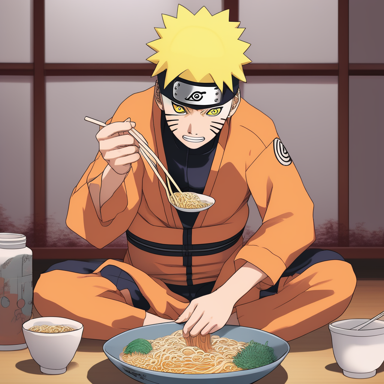

Generating: Bill Gates in Naruto style


  0%|          | 0/30 [00:00<?, ?it/s]

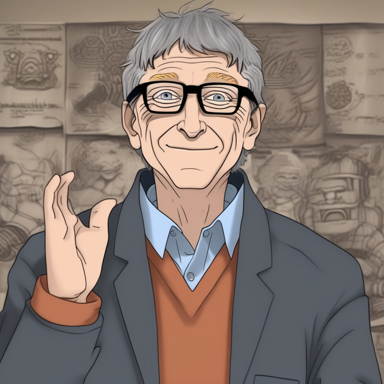

Generating: A boy with blue eyes in Naruto style


  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
from diffusers import StableDiffusionXLPipeline, AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTextModelWithProjection, CLIPTokenizer
from IPython.display import display
import torch
import os

# --- 1. Define Paths ---
BASE_MODEL_PATH = "/content/drive/MyDrive/sdxl-base-1.0"
LORA_WEIGHTS_PATH = "/content/drive/MyDrive/Naruto_FineTune/final_weights"
# Note: Make sure LORA path is correct (check if 'final_weights' exists or if it's just the folder)

prompts = [
    "Naruto Uzumaki eating ramen",
    "Bill Gates in Naruto style",
    "A boy with blue eyes in Naruto style",
]

# --- 2. Load Components Individually from Drive ---
print("Loading components from Drive...")

# Load Tokenizers
tokenizer = CLIPTokenizer.from_pretrained(BASE_MODEL_PATH, subfolder="tokenizer")
tokenizer_2 = CLIPTokenizer.from_pretrained(BASE_MODEL_PATH, subfolder="tokenizer_2")

# Load Text Encoders
text_encoder = CLIPTextModel.from_pretrained(BASE_MODEL_PATH, subfolder="text_encoder", torch_dtype=torch.float16)
text_encoder_2 = CLIPTextModelWithProjection.from_pretrained(BASE_MODEL_PATH, subfolder="text_encoder_2", torch_dtype=torch.float16)

# Load VAE
vae = AutoencoderKL.from_pretrained(BASE_MODEL_PATH, subfolder="vae", torch_dtype=torch.float16)

# Load UNet
unet = UNet2DConditionModel.from_pretrained(BASE_MODEL_PATH, subfolder="unet", torch_dtype=torch.float16)

# Load Scheduler
scheduler = DDPMScheduler.from_pretrained(BASE_MODEL_PATH, subfolder="scheduler")

print("Components loaded. Assembling pipeline...")

# --- 3. Create the Pipeline Manually ---
pipe = StableDiffusionXLPipeline(
    vae=vae,
    text_encoder=text_encoder,
    text_encoder_2=text_encoder_2,
    tokenizer=tokenizer,
    tokenizer_2=tokenizer_2,
    unet=unet,
    scheduler=scheduler
)
pipe.to("cuda")

# --- 4. Load LoRA Weights ---
print(f"Loading LoRA adapters from: {LORA_WEIGHTS_PATH}")
try:
    pipe.load_lora_weights(LORA_WEIGHTS_PATH)
    print("✅ LoRA weights loaded successfully!")
except Exception as e:
    print(f"⚠️ Could not load LoRA weights: {e}")
    print("Check if the path is correct or if the file exists.")

# --- 5. Run Inference ---
generator = torch.Generator("cuda").manual_seed(42)

print("Starting generation...")
for prompt in prompts:
    print(f"Generating: {prompt}")
    image = pipe(
        prompt=prompt,
        num_inference_steps=30,
        guidance_scale=7.5,
        generator=generator
    ).images[0]

    display(image.resize((384, 384)))

print("✅ Inference complete.")

In [ ]:
print("Rasengan-XL Loading and Generating Images!")

# load the pipeline
lora_pipe = StableDiffusionXLPipeline.from_pretrained(
    BASE_MODEL_ID,
    torch_dtype=torch.float16,
    use_safetensors=True
).to("cuda")

# -load lora wts
print(f"Loading LoRA weights from: {LORA_WEIGHTS_PATH}")
lora_pipe.load_lora_weights(LORA_WEIGHTS_PATH)
print("LoRA weights loaded successfully.")

lora_images = []
generator = torch.Generator("cuda").manual_seed(42)

for prompt in prompts:
    print(f"Generating: '{prompt}'")
    image = lora_pipe(
        prompt=prompt,
        num_inference_steps=30,
        guidance_scale=7.5,
        generator=generator
    ).images[0]
    lora_images.append(image)

print("Raseeengannnnnnnn!!!!!!!!!!!!!!!!!!!")


del lora_pipe
torch.cuda.empty_cache()
gc.collect()